In [1]:
from my_krml_24886400.data.sets import get_data_from_gdrive, merge_dataframes_on_common_columns
from my_krml_24886400.visualisation.plot import distribution_plot, categorical_plot, relationship_plot
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import warnings
from sklearn.preprocessing import LabelEncoder
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

warnings.filterwarnings('ignore')

In [2]:
file_path = '../../data'
os.makedirs(file_path, exist_ok=True)

# load raw data files
df_train = get_data_from_gdrive(url='https://drive.google.com/file/d/1-0x5Vfri1i-OL3ek2GnhZGye-4eqbqQA/view', file_path=file_path)
df_items = get_data_from_gdrive('https://drive.google.com/file/d/1--W-RjAnypyvbwUCsSZVldrA2Ja2jtDA/view', file_path)
df_cal = get_data_from_gdrive('https://drive.google.com/file/d/1-6cH8c0tKTFu8EzMJyVfdhxrny6rdgrM/view', file_path)
df_events = get_data_from_gdrive('https://drive.google.com/file/d/1_RmDGfRTMkqF4OO9NibNoRhbEjc0OZW4/view', file_path)

../../data/1-0x5Vfri1i-OL3ek2GnhZGye-4eqbqQA.csv already exists. Reading the file from the local directory.
../../data/1--W-RjAnypyvbwUCsSZVldrA2Ja2jtDA.csv already exists. Reading the file from the local directory.
../../data/1-6cH8c0tKTFu8EzMJyVfdhxrny6rdgrM.csv already exists. Reading the file from the local directory.
../../data/1_RmDGfRTMkqF4OO9NibNoRhbEjc0OZW4.csv already exists. Reading the file from the local directory.


In [3]:
# Melt the train_df to have a long format
df_train = pd.melt(df_train,
         id_vars=['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'],
         var_name='d',
         value_name='item_sold')

In [4]:
dataframe_list = [df_train, df_cal, df_events, df_items]

sales_data = merge_dataframes_on_common_columns(dataframe_list)
sales_data.shape

['d']
['date']
['store_id', 'wm_yr_wk', 'item_id']


(47107050, 13)

In [5]:
sales_data.shape

(47107050, 13)

In [6]:
sales_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47107050 entries, 0 to 47107049
Data columns (total 13 columns):
 #   Column      Dtype  
---  ------      -----  
 0   id          object 
 1   item_id     object 
 2   dept_id     object 
 3   cat_id      object 
 4   store_id    object 
 5   state_id    object 
 6   d           object 
 7   item_sold   int64  
 8   date        object 
 9   wm_yr_wk    int64  
 10  event_name  object 
 11  event_type  object 
 12  sell_price  float64
dtypes: float64(1), int64(2), object(10)
memory usage: 4.6+ GB


In [7]:
sales_data.isna().sum()

id                   0
item_id              0
dept_id              0
cat_id               0
store_id             0
state_id             0
d                    0
item_sold            0
date                 0
wm_yr_wk             0
event_name    43143350
event_type    43143350
sell_price    12291876
dtype: int64

In [8]:
sales_data['revenue'] = sales_data['item_sold'] * sales_data['sell_price']

In [9]:
# Drop rows where 'revenue' has NaN values
sales_data_cleaned = sales_data.dropna(subset=['revenue'])

<Figure size 600x400 with 0 Axes>

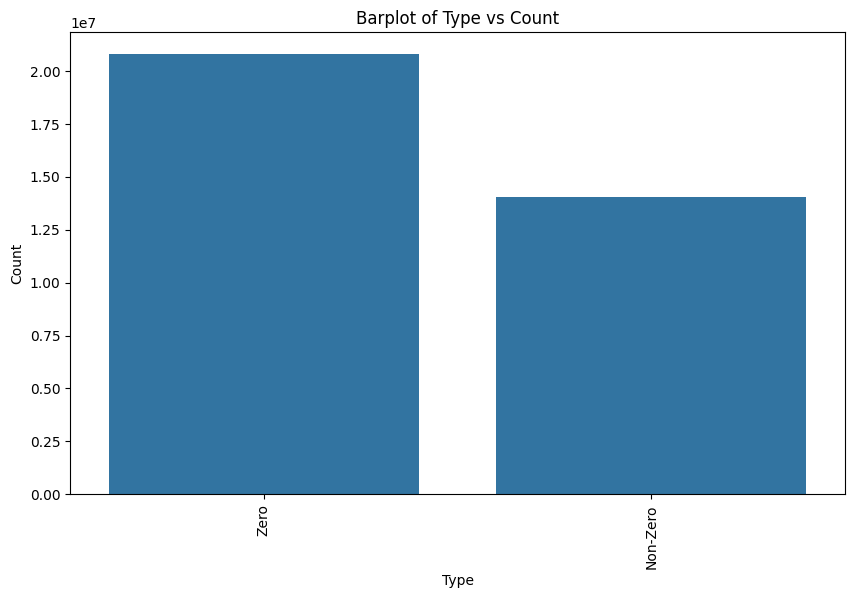

In [10]:
# Count zero and non-zero revenue
zero_count = (sales_data_cleaned['revenue'] == 0).sum()
non_zero_count = (sales_data_cleaned['revenue'] != 0).sum()

# Create a DataFrame for plotting
revenue_counts = pd.DataFrame({
    'Type': ['Zero', 'Non-Zero'],
    'Count': [zero_count, non_zero_count]
})

# Plot the counts
plt.figure(figsize=(6, 4))
categorical_plot(revenue_counts, kind='barplot', x = 'Type', y='Count')

In [11]:
sales_data_cleaned['event_type'] = sales_data_cleaned['event_type'].fillna('Normal')

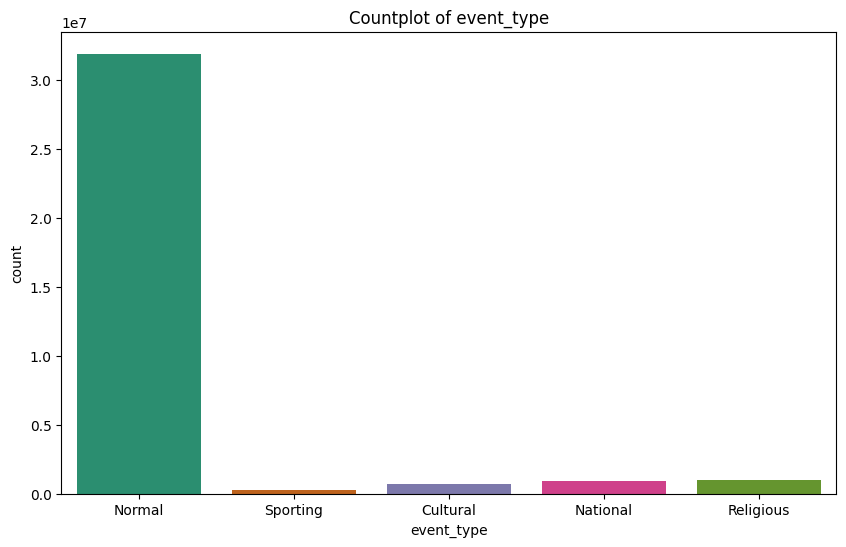

In [12]:
distribution_plot(df=sales_data_cleaned, x='event_type', kind='countplot')

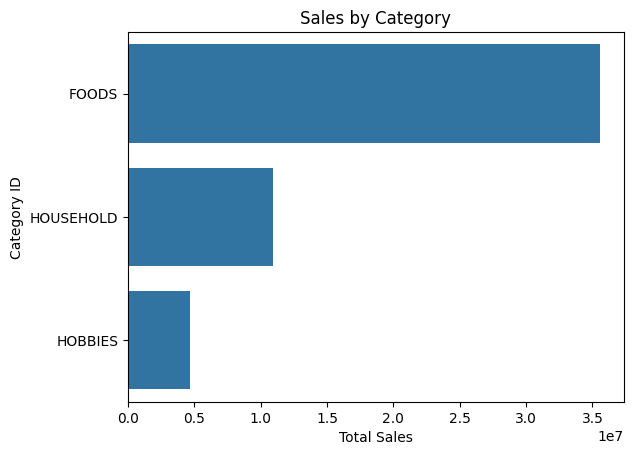

In [13]:
# Sales by Category
cat_sales = sales_data_cleaned.groupby('cat_id')['item_sold'].sum().sort_values(ascending=False)
sns.barplot(x=cat_sales.values, y=cat_sales.index)
plt.title('Sales by Category')
plt.xlabel('Total Sales')
plt.ylabel('Category ID')
plt.show()

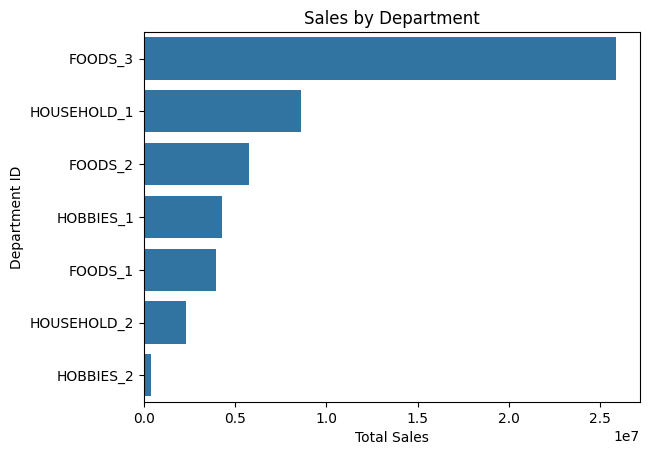

In [14]:
# Sales by Department
dept_sales = sales_data_cleaned.groupby('dept_id')['item_sold'].sum().sort_values(ascending=False)
sns.barplot(x=dept_sales.values, y=dept_sales.index)
plt.title('Sales by Department')
plt.xlabel('Total Sales')
plt.ylabel('Department ID')
plt.show()

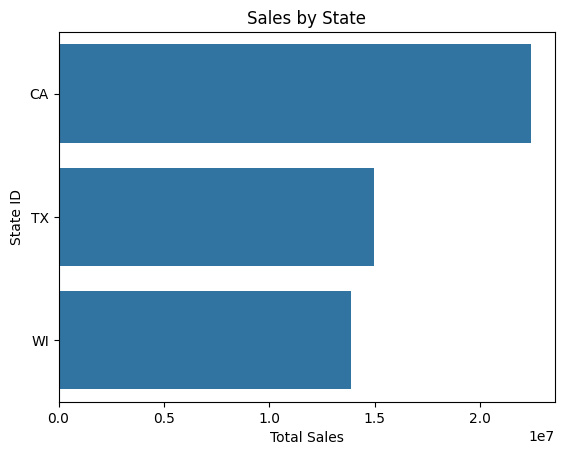

In [15]:
# Sales by State
state_sales = sales_data_cleaned.groupby('state_id')['item_sold'].sum().sort_values(ascending=False)
sns.barplot(x=state_sales.values, y=state_sales.index)
plt.title('Sales by State')
plt.xlabel('Total Sales')
plt.ylabel('State ID')
plt.show()

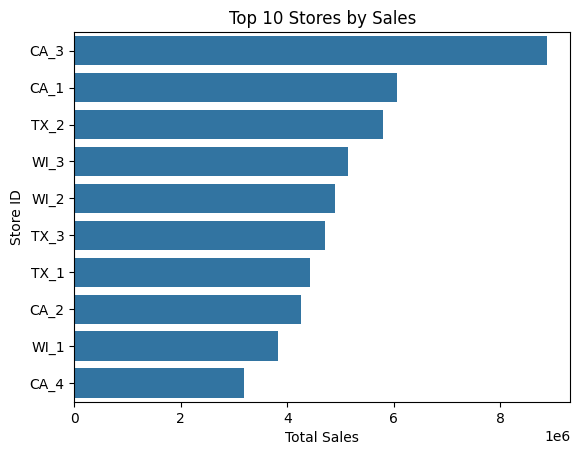

In [16]:
# Sales by Store
store_sales = sales_data_cleaned.groupby('store_id')['item_sold'].sum().sort_values(ascending=False).head(10)  # Top 10 stores
sns.barplot(x=store_sales.values, y=store_sales.index)
plt.title('Top 10 Stores by Sales')
plt.xlabel('Total Sales')
plt.ylabel('Store ID')
plt.show()

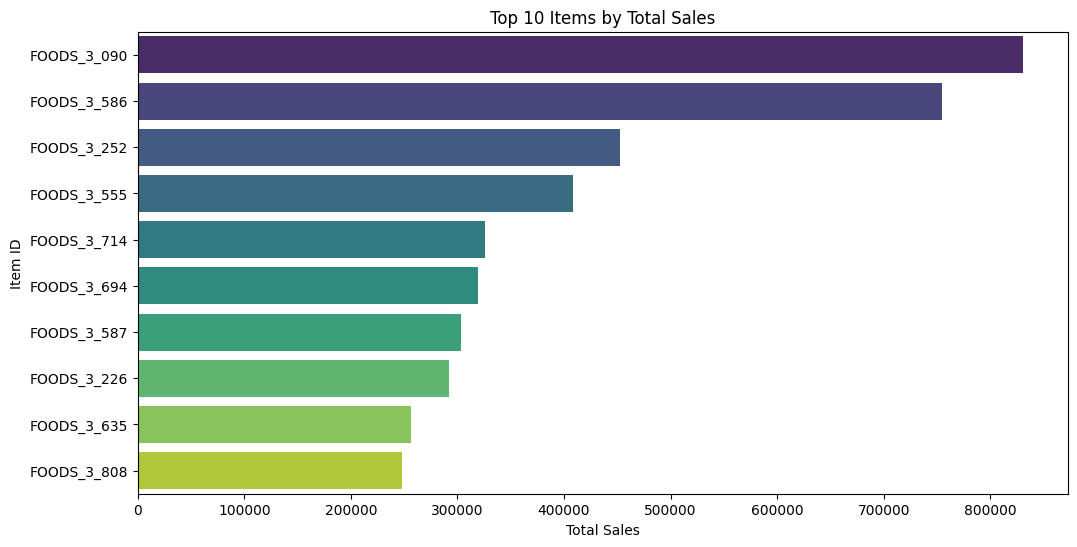

In [17]:
top_items = sales_data_cleaned.groupby('item_id')['item_sold'].sum().sort_values(ascending=False).head(10)
plt.figure(figsize=(12,6))
sns.barplot(x=top_items.values, y=top_items.index, palette='viridis')
plt.title('Top 10 Items by Total Sales')
plt.xlabel('Total Sales')
plt.ylabel('Item ID')
plt.show()

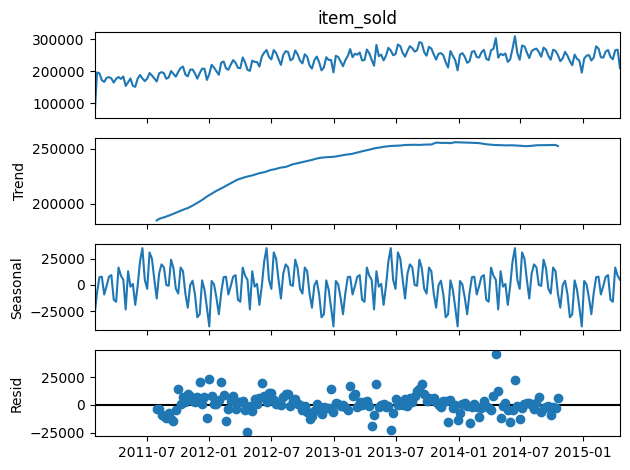

In [18]:
# Ensure the 'date' column is in datetime format and set it as the index
sales_data_cleaned['date'] = pd.to_datetime(sales_data_cleaned['date'])
sales_over_time = sales_data_cleaned.set_index('date')

# Ensure the data is sorted by date
sales_over_time = sales_over_time.sort_values(by='date')

# Resample sales data weekly
weekly_sales = sales_over_time['item_sold'].resample('W').sum()

# Decompose the time series
decomposition = seasonal_decompose(weekly_sales, model='additive')

# Plot the decomposition
decomposition.plot()
plt.show()

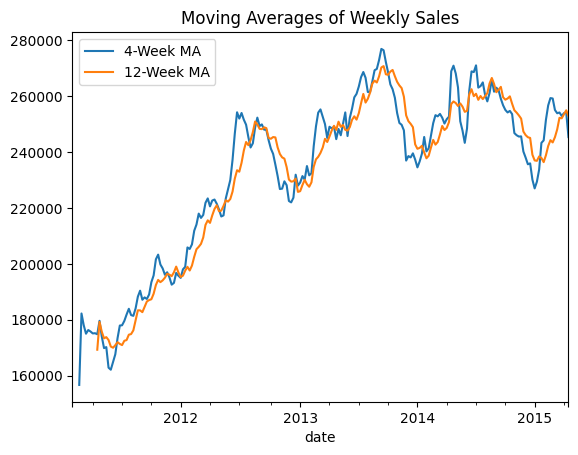

In [19]:
weekly_sales.rolling(window=4).mean().plot(label='4-Week MA')
weekly_sales.rolling(window=12).mean().plot(label='12-Week MA')
plt.legend()
plt.title('Moving Averages of Weekly Sales')
plt.show()

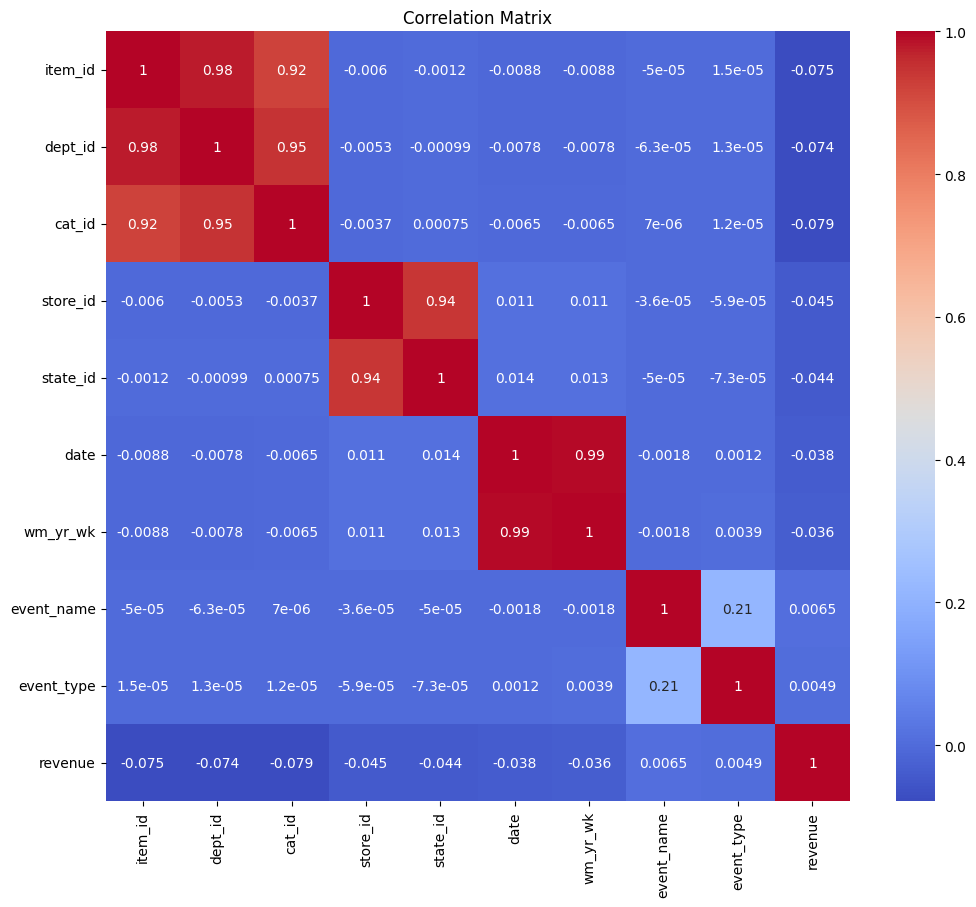

In [20]:
# Create a copy of the DataFrame to avoid altering original data
df_encoded = sales_data_cleaned.copy()


identifier_columns = ['id', 'item_sold', 'd', 'sell_price']

# Drop the identifier columns from the DataFrame if they exist
df_encoded = df_encoded.drop(columns=identifier_columns, errors='ignore')

# Loop through each column and apply Label Encoding to categorical columns
label_encoder = LabelEncoder()

for col in df_encoded.columns:
    if df_encoded[col].dtype == 'object':  # Check if column is of type object (string/categorical)
        df_encoded[col] = label_encoder.fit_transform(df_encoded[col])

# Calculate the correlation matrix
corr_matrix = df_encoded.corr()

# Set the figure size before plotting
plt.figure(figsize=(12, 10))  # Adjust the size as needed (width, height)

# Create the heatmap
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [21]:
def extract_date_features_from_string(df, column_date):
    """
    Function to extract date features from a date string.
    
    Parameters:
    date_str (str): The input date string.
    
    Returns:
    dict: Dictionary with extracted date features (year, month, day, dayofweek).
    """
    df[column_date] = pd.to_datetime(df[column_date])
    df['year'] = df[column_date].dt.year
    df['month'] = df[column_date].dt.month
    df['day'] = df[column_date].dt.day
    return df

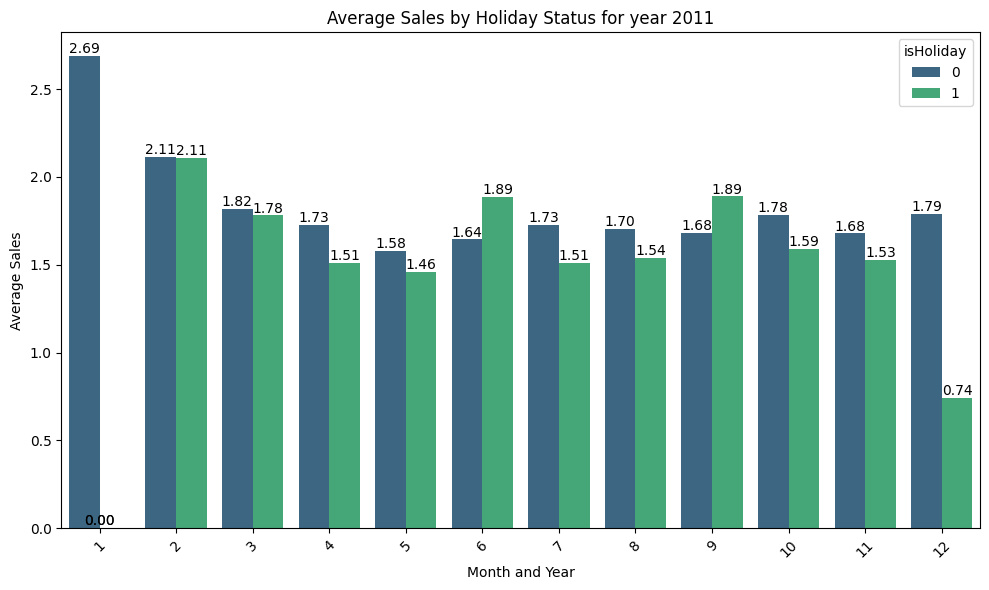

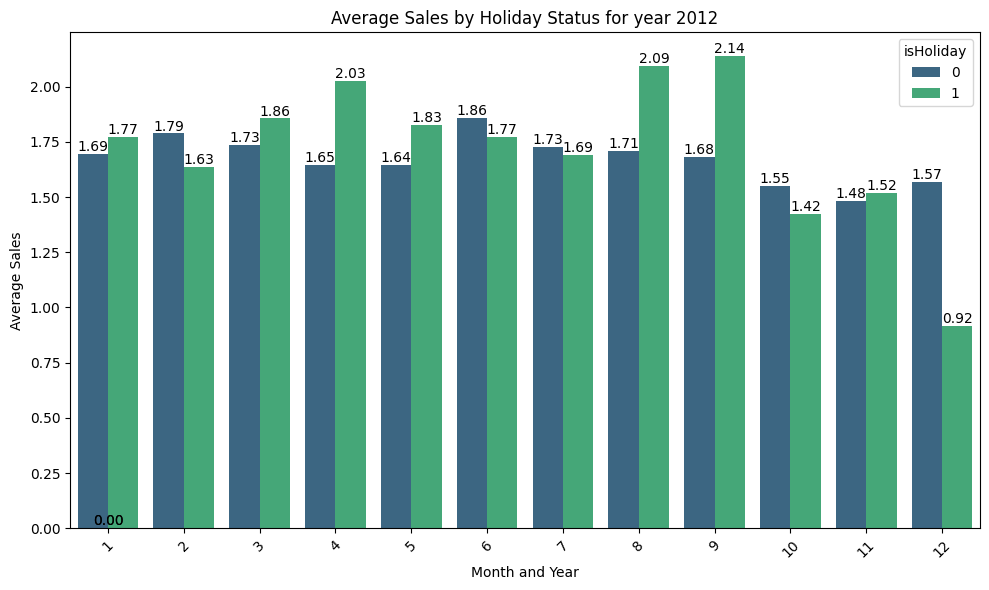

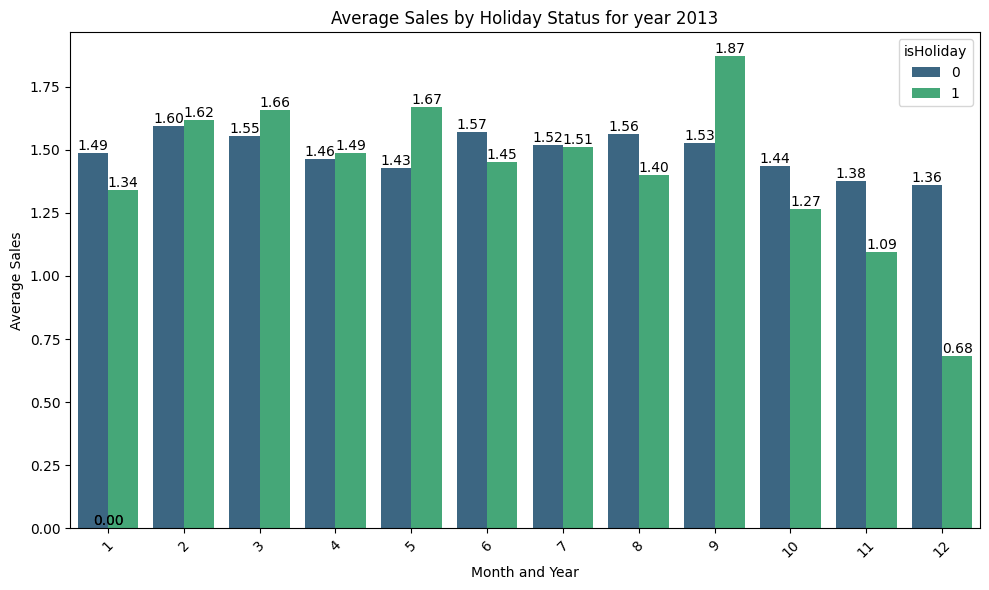

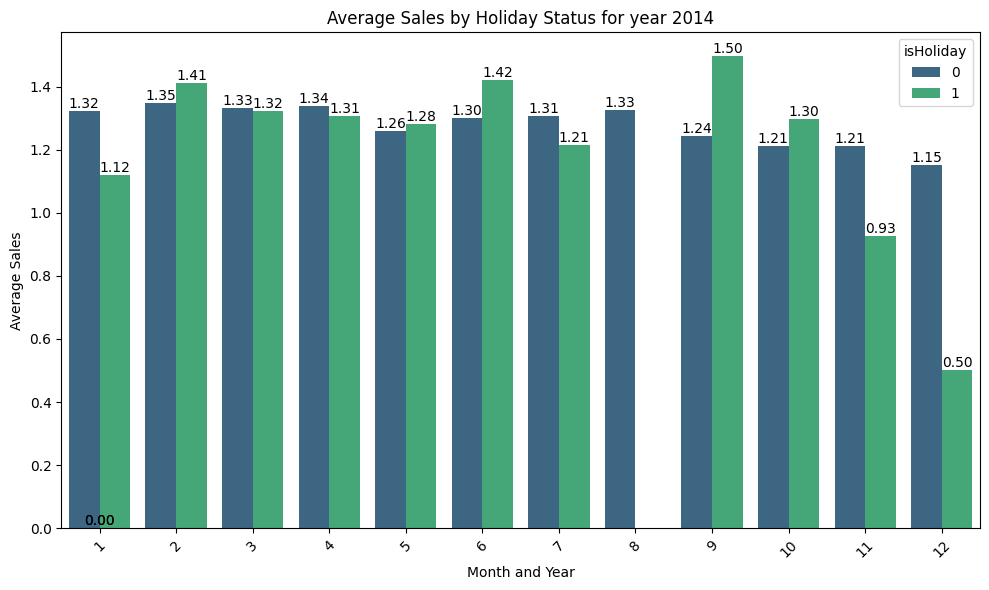

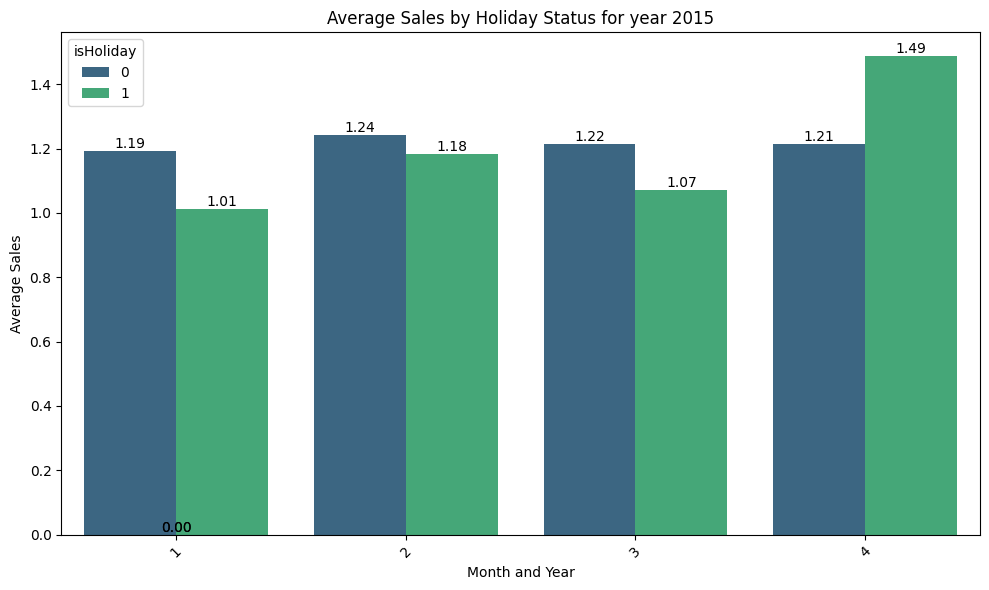

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sd = sales_data_cleaned.copy()
# Extract date features
sd = extract_date_features_from_string(sd, 'date')

sd['isHoliday'] = sd['event_type'].apply(lambda x: 1 if x!='Normal' else 0)

# Calculate average sales by event type, month, and year
sales_distribution = sd.groupby(['isHoliday', 'month', 'year'])['item_sold'].mean().reset_index()


# Rename columns for clarity
sales_distribution.columns = ['isHoliday', 'month', 'year', 'Average Sales']

for year in sales_distribution.year.unique():
    sd_data = sales_distribution[sales_distribution['year'] == year]
    # Plotting
    plt.figure(figsize=(10, 6))
    bar_plot = sns.barplot(x='month', y='Average Sales', hue='isHoliday', data=sd_data, palette='viridis')
    
    # Annotate bars
    for p in bar_plot.patches:
        bar_plot.annotate(format(p.get_height(), '.2f'), 
                          (p.get_x() + p.get_width() / 2., p.get_height()), 
                          ha='center', va='center', 
                          xytext=(0, 5), 
                          textcoords='offset points')
    
    plt.title(f'Average Sales by Holiday Status for year {year}')
    plt.ylabel('Average Sales')
    plt.xlabel('Month and Year')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


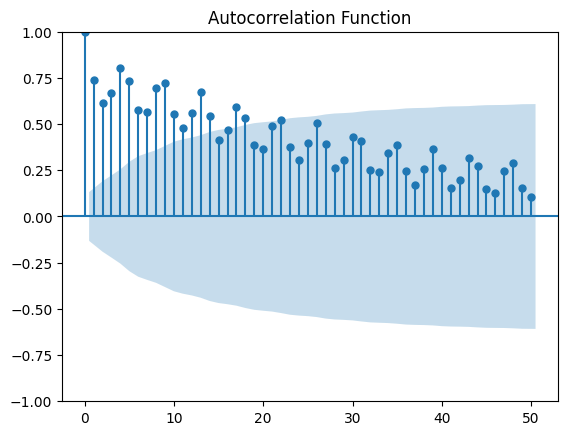

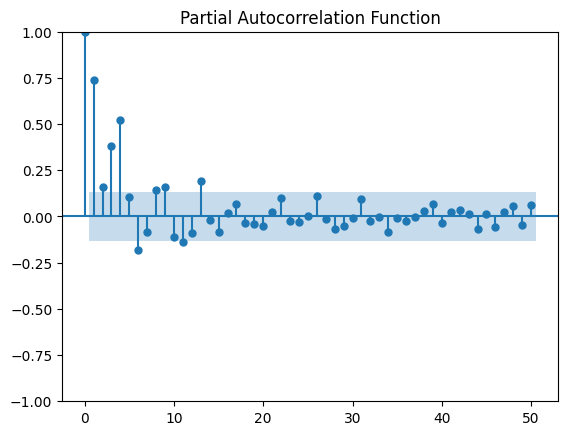

In [25]:
# Plot ACF
plot_acf(weekly_sales, lags=50)
plt.title('Autocorrelation Function')
plt.show()

# Plot PACF
plot_pacf(weekly_sales, lags=50)
plt.title('Partial Autocorrelation Function')
plt.show()